# Exercise 1

Authors:
    - Tuoxing Liu

## 1. Exploring the Data

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


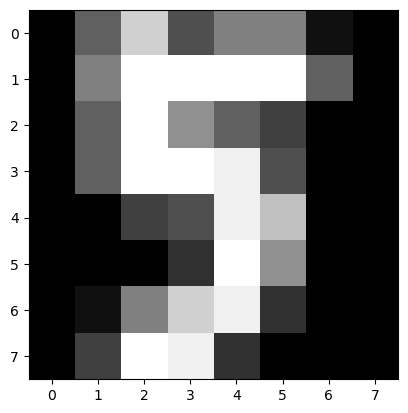

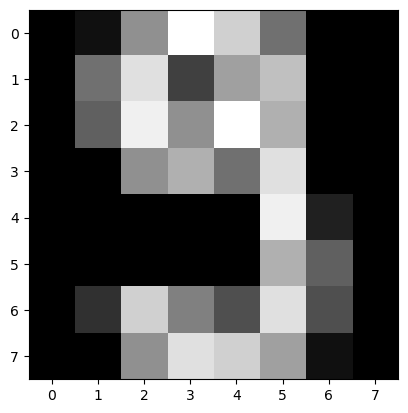

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt

img = digits.images[33]


def print_img(img):
    assert 2 == len(img.shape)
    plt.figure()
    plt.gray()
    plt.imshow(img, interpolation="nearest")  # bicubic, nearest
    plt.show()


print_img(img)


def print_data(data):
    data_temp = data.reshape(8, 8)
    print_img(data_temp)


print_data(digits.data[39])

In [3]:
from sklearn import model_selection
import numpy as np

filter_mask = np.logical_or(target == 3, target == 9)

X_all = data[filter_mask]
y_all = target[filter_mask]

y_all[y_all == 3] = -1
y_all[y_all == 9] = 1
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(
        X_all, y_all, test_size=0.4, random_state=0)

## 2. Hand-crafted classifier

### 2.1 Feature construcition

In [4]:
from sklearn.preprocessing import MinMaxScaler


def features2d(datas):
    features = []
    for data in datas:
        mask = data > 12
        temp = [data[18]+data[26]+data[34]+data[42],
                data[11]+data[19]-data[35]-data[43]]
        features.append(temp)

    # normalize
    features_norm = MinMaxScaler().fit_transform(features)

    return features_norm

### 2.2 Scatterplot

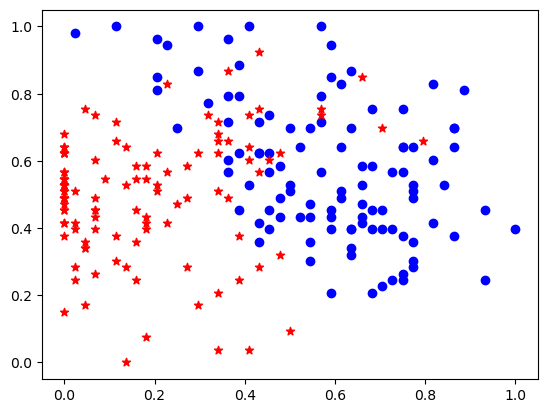

In [5]:
# X_train
# y_train

features = features2d(X_train)


def draw_feature(features, label):
    for feature, y in zip(features, label):
        if y == 3 or y == -1:
            marker = "*"
            color = "red"
        elif y == 9 or y == 1:
            marker = "o"
            color = "blue"
        plt.scatter(feature[0], feature[1], marker=marker, color=color)
        # plt.show()


draw_feature(features, y_train)

### 2.3 Decision rule


In [6]:
def nearest_mean(training_features, training_labels, test_festures):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    f_negetive = t_features[t_labels == -1].mean(axis=0)
    f_positive = t_features[t_labels == 1].mean(axis=0)

    labels = []
    for f in test_festures:
        if abs(f-f_negetive).sum() > abs(f-f_positive).sum():
            labels.append(1)
        else:
            labels.append(-1)

    return labels


train_features = features2d(X_train)
x_new = features2d(X_test)

test_labels = nearest_mean(train_features, y_train, x_new)
train_labels = nearest_mean(train_features, y_train, train_features)

training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

training error: 0.1336405529953917
test error: 0.11643835616438356


### 2.4 Visualize the decision regions

40000


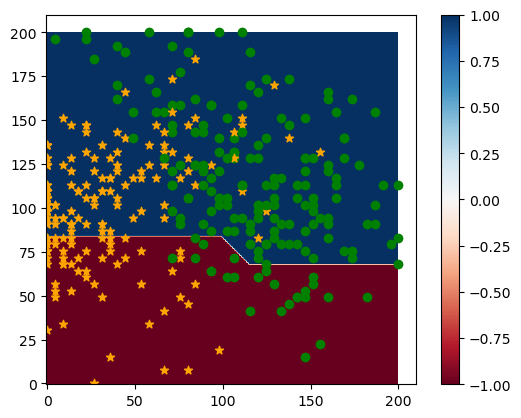

40000


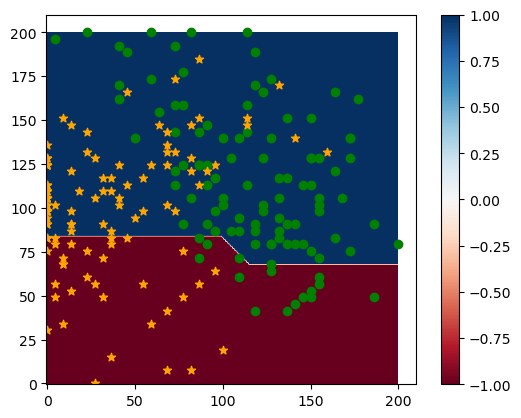

In [7]:
import itertools

# f_negetive = t_features[t_labels == -1].mean()
# f_positive = t_features[t_labels == 1].mean()


def draw_decision_region(X, y):
    f1 = np.linspace(0, 1, 200)
    f2 = np.linspace(0, 1, 200)

    mesh_f = list(itertools.product(f1, f2))
    mesh_decision = nearest_mean(train_features, y_train, mesh_f)
    print(len(mesh_decision))

    cmap = plt.cm.RdBu
    norm = plt.Normalize(-1, 1)

    plt.imshow(np.array(mesh_decision).reshape(200, 200),
               cmap=cmap, norm=norm, origin='lower')
    plt.colorbar()
    X_all_scale = [x*200 for x in features2d(X)]
    # draw_feature(X_all_scale,y_all)
    for feature, y in zip(X_all_scale, y):
        if y == -1:
            marker = "*"
            color = "orange"
        elif y == 1:
            marker = "o"
            color = "green"
        plt.scatter(feature[0], feature[1], marker=marker, color=color)
    plt.show()


draw_decision_region(X_all, y_all)
draw_decision_region(X_train, y_train)

## 3. LDA

### 3.1 Implement LDA training

In [8]:
def fit_lad(training_features, training_labels):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    x_negetive = t_features[t_labels == -1]
    x_positive = t_features[t_labels == 1]
    mu_negetive = x_negetive.mean(axis=0)
    mu_positive = x_positive.mean(axis=0)

    covmat = ((x_negetive - mu_negetive).T @ (x_negetive - mu_negetive) +
              (x_positive - mu_positive).T @ (x_positive - mu_positive)
              ) / len(training_labels)

    counts = [np.sum(t_labels == k) for k in {-1, 1}]
    p = [count / len(t_labels) for count in counts]

    return [mu_negetive, mu_positive], covmat, p


fit_lad(X_train, y_train)
mu, covmat, p = fit_lad(features2d(X_train), y_train)

### 3.2 Implement LDA prediction



In [9]:

def predict_lda(mu, covmat, p, test_features):
    [mu_neg, mu_pos] = mu
    # print((mu_pos - mu_neg).shape)
    # print(covmat.shape)
    # print(np.linalg.pinv(covmat).shape) # it should be inv not pinv, but I don't know why covmat is a singular matrix in my code
    beta = 2 * np.linalg.pinv(covmat) @ mu_pos - mu_neg.T
    b = mu_neg @ np.linalg.pinv(covmat) @ mu_neg.T - \
        mu_pos @ np.linalg.pinv(covmat) @ mu_pos.T

    return np.sign(test_features @ beta + b)


train_predicted = predict_lda(mu, covmat, p, features2d(X_train))
test_predicted = predict_lda(mu, covmat, p, features2d(X_test))

training_error = abs(train_predicted - y_train).sum()/(2*len(y_train))
test_error = abs(test_predicted - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

training error: 0.4792626728110599
test error: 0.4246575342465753


40000


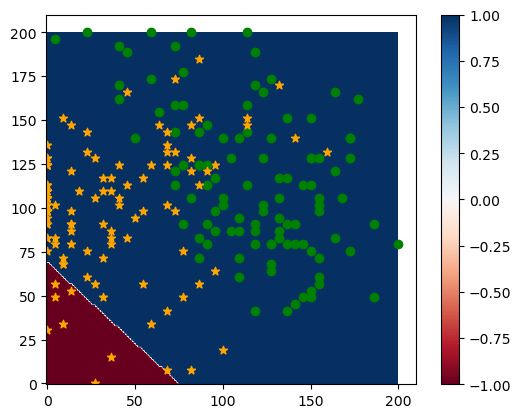

In [10]:
# def draw_decision_region2(X, y):
f1 = np.linspace(0, 1, 200)
f2 = np.linspace(0, 1, 200)

mesh_f = list(itertools.product(f1, f2))
mesh_decision = predict_lda(mu, covmat, p, mesh_f)
print(len(mesh_decision))

cmap = plt.cm.RdBu
norm = plt.Normalize(-1, 1)

plt.imshow(np.array(mesh_decision).reshape(200, 200),
            cmap=cmap, norm=norm, origin='lower')
plt.colorbar()
X_scale = [x*200 for x in features2d(X_train)]
# draw_feature(X_all_scale,y_all)
for feature, y in zip(X_scale, y_train):
    if y == -1:
        marker = "*"
        color = "orange"
    elif y == 1:
        marker = "o"
        color = "green"
    plt.scatter(feature[0], feature[1], marker=marker, color=color)
plt.show()

## 4. SVM

In [11]:
def ReLU(x):
    return np.maximum(0, x)


def loss_svm(beta, b, weight, X, y):
    print((X @ beta + b).shape)
    print((y*(X @ beta + b)).shape)
    return 0.5*beta.T@beta + weight/len(y) * np.sum(ReLU(1-y*(X @ beta + b)), axis=0)


def loss_partial_beta(beta, b, weight, X, y):
    wrong_filter = y*(X@beta+b) < 1
    X_wrong = X[wrong_filter]
    y_wrong = y[wrong_filter].reshape(-1, 1)
    return beta + weight/len(y) * np.sum(-y_wrong*X_wrong, axis=0)


def loss_partial_b(beta, b, weight, X, y):
    wrong_filter = y*(X@beta+b) < 1
    y_wrong = y[wrong_filter].reshape(-1, 1)

    return weight/len(y) * np.sum(-y_wrong)


def fit_svm(training_features, training_labels, T=100, weight=0.5, learning_rate=0.8):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    beta = np.random.normal(0, 1, t_features.shape[1])
    b = 0

    training_errors = []
    for i in range(T):
        if i % 5 == 0:
            learning_rate *= 0.5
        beta = beta - learning_rate * \
            loss_partial_beta(beta, b, weight, t_features, t_labels)
        b = b - learning_rate * \
            loss_partial_b(beta, b, weight, t_features, t_labels)

        train_labels = predict_svm(beta, b, t_features)
        training_error = abs(train_labels - t_labels).sum()/(2*len(t_labels))
        training_errors.append(training_error)

    return beta, b, training_errors


def predict_svm(beta, b, test_features):
    return np.sign(test_features @ beta + b)

### SVM on 2d features

[0.09016039 0.00714568] -0.04608290536063057
training error: 0.16589861751152074
test error: 0.15753424657534246


Text(0, 0.5, 'learning error')

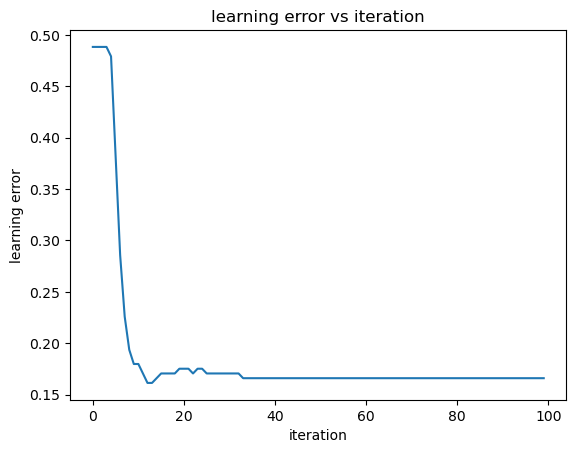

In [12]:
beta,b,errors = fit_svm(features2d(X_train),y_train)
print(beta,b)

train_labels = predict_svm(beta,b,features2d(X_train))
test_labels = predict_svm(beta,b,features2d(X_test))

training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

plt.plot(range(len(errors)),errors)
plt.title("learning error vs iteration")
plt.xlabel("iteration")
plt.ylabel("learning error")

### SVM on 64d features

training error: 0.009216589861751152
test error: 0.02054794520547945


Text(0, 0.5, 'learning error')

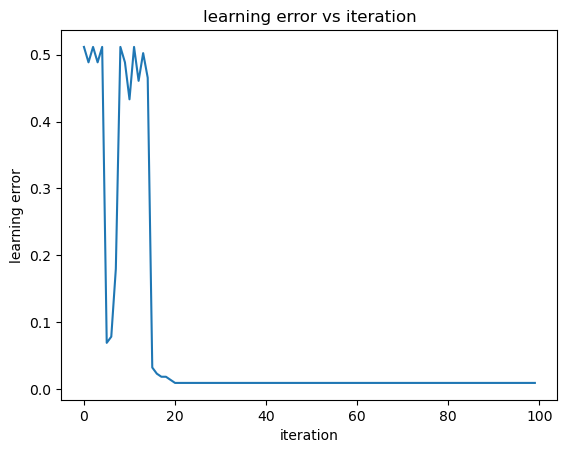

In [13]:
beta,b,errors = fit_svm(X_train,y_train)
# print(beta,b)

train_labels = predict_svm(beta,b,X_train)
test_labels = predict_svm(beta,b,X_test)

training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

plt.plot(range(len(errors)),errors)
plt.title("learning error vs iteration")
plt.xlabel("iteration")
plt.ylabel("learning error")

### Cross validation for weight(lambda)

In [14]:
from sklearn.model_selection import KFold

def cross_validation(X,y,weights,n_splits=10):
    # create a 5-fold cross-validation iterator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    errors=[]
    for weight in weights:
        test_errors=[]
        # loop over the folds and train/test the model on each fold
        for train_index, test_index in kf.split(X):
            # get the training and test data for this fold
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # train the model on the training data for this fold
            beta,b,_=fit_svm(X_train,y_train,weight = weight)

            # evaluate the model on the test data for this fold
            test_labels = predict_svm(beta,b,X_test)
            test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
            test_errors.append(test_error)

        error=np.array(test_errors).mean()
        errors.append(error)
        print(f"weight:{weight}, error:{error}")

    best_weight=weights[np.argmin(errors)]
    best_error = errors[np.argmin(errors)]
    print(f"best weight:{best_weight}, best training error:{best_error}")
    return best_weight,best_error

cross_validation(X_train,y_train,np.linspace(0,1,100))

weight:0.0, error:0.4887445887445887
weight:0.010101010101010102, error:0.054978354978354974
weight:0.020202020202020204, error:0.022943722943722943
weight:0.030303030303030304, error:0.027705627705627706
weight:0.04040404040404041, error:0.013852813852813853
weight:0.05050505050505051, error:0.013852813852813853
weight:0.06060606060606061, error:0.009307359307359308
weight:0.07070707070707072, error:0.013852813852813853
weight:0.08080808080808081, error:0.009307359307359308
weight:0.09090909090909091, error:0.009307359307359308
weight:0.10101010101010102, error:0.018614718614718615
weight:0.11111111111111112, error:0.013852813852813853
weight:0.12121212121212122, error:0.013852813852813853
weight:0.13131313131313133, error:0.013852813852813853
weight:0.14141414141414144, error:0.013852813852813853
weight:0.15151515151515152, error:0.02316017316017316
weight:0.16161616161616163, error:0.009307359307359308
weight:0.17171717171717174, error:0.013852813852813853
weight:0.18181818181818182

(0.06060606060606061, 0.009307359307359308)

The best weight should be 0.06 and the best training error is 0.009307359307359308

### Visualize the decision boundary

### Compare with sklearn.svm